# Downloading and Importing Relevant Packages for Project

In [ ]:
!pip install ucimlrepo
!pip install attrs packaging editables pandas scikit-learn sortedcontainers gmpy2 matplotlib
!pip install gosdt

# ensures that fastsparsegams can run
# fastsparsegams has been marred by the
# sinister appetite of software deprecation
!pip install 'numpy<2.0'
# This will throw an error but it will still work. Don't be scared of the red.
!pip install 'scipy<1.13.0'
!pip install fastsparsegams

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

from matplotlib.colors import LinearSegmentedColormap
import fastsparsegams as fsg

# Dataset Fetching and Exploratory Data Analysis

In [ ]:
# fetch dataset
glioma_grading_clinical_and_mutation_features = fetch_ucirepo(id=759)

# data (as pandas dataframes)
X = glioma_grading_clinical_and_mutation_features.data.features
y = glioma_grading_clinical_and_mutation_features.data.targets

In [ ]:
non_genes = ['Age_at_diagnosis', 'Gender', 'Race']

def get_valuescnts(column, data, levels = None):
  unique_vals = data[column].unique()
  vals = levels if levels != None else [str(level) for level in unique_vals]
  cnts = [int(data.loc[data[column] == i, data.columns == column].size) for i in unique_vals]
  return (vals, cnts)

def plot_categorical(column, data, levels = None):
  vals, cnts = get_valuescnts(column, data, levels)
  plt.bar(vals, cnts)
  plt.xlabel(f'{column}')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {column}')
  plt.show()

def plot_continuous(column, data):
  plt.hist(data[column])
  plt.xlabel(f'{column}')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of {column}')
  plt.show()

def plot_mutation_counts(data, rows = 4, cols = 5, fs = (20, 10)):
  fig, axs = plt.subplots(nrows = rows, ncols = cols, sharex = True, \
                          sharey = True, figsize = fs)
  axs = axs.flatten()
  i = 0
  for column in data.columns:
    if column in non_genes:
      continue
    vals, cnts = get_valuescnts(column, data, levels = ['Wild-Type', 'Mutated'])
    axs[i].bar(vals, cnts)
    axs[i].set_title(f'{column}')
    i += 1
  #plt.tight_layout()
  fig.suptitle("Mutation Counts of Various Genes", fontweight = 'bold')
  fig.text(0.5, 0.04, 'Mutation Status (0 = Wild Type/Normal, 1 = Mutated)', ha='center', fontsize=14)  # X-axis label
  fig.text(0.04, 0.5, 'Frequency in Training Data', va='center', rotation='vertical', fontsize=14)  # Y-axis label
  plt.show()


Size of Dataset:  839
Grade
0        0.579732
1        0.420268
Name: proportion, dtype: float64
Size of Dataset:  671


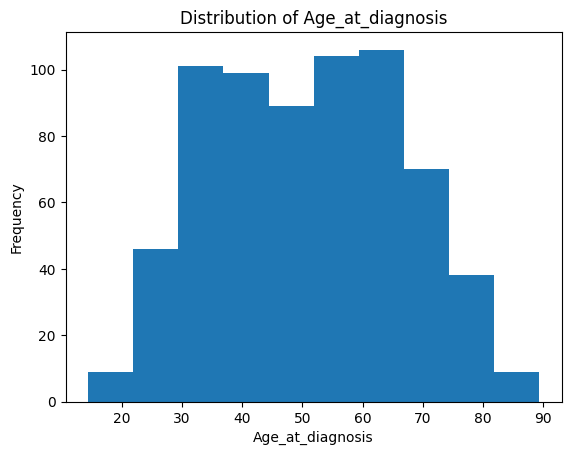

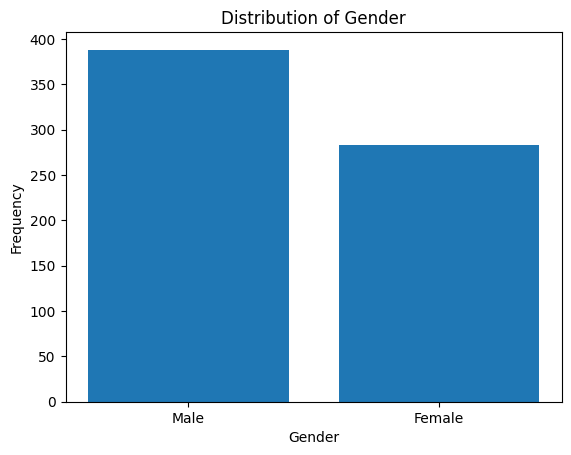

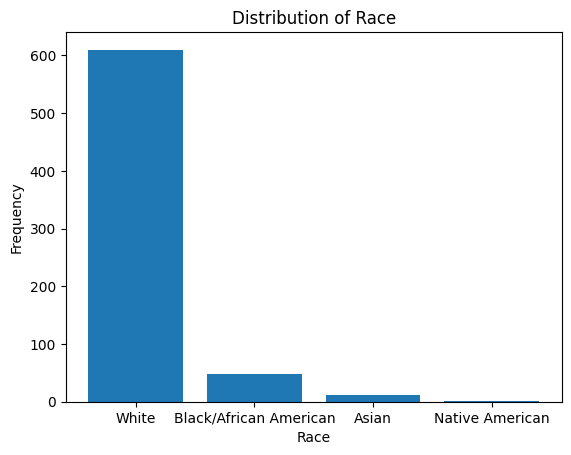

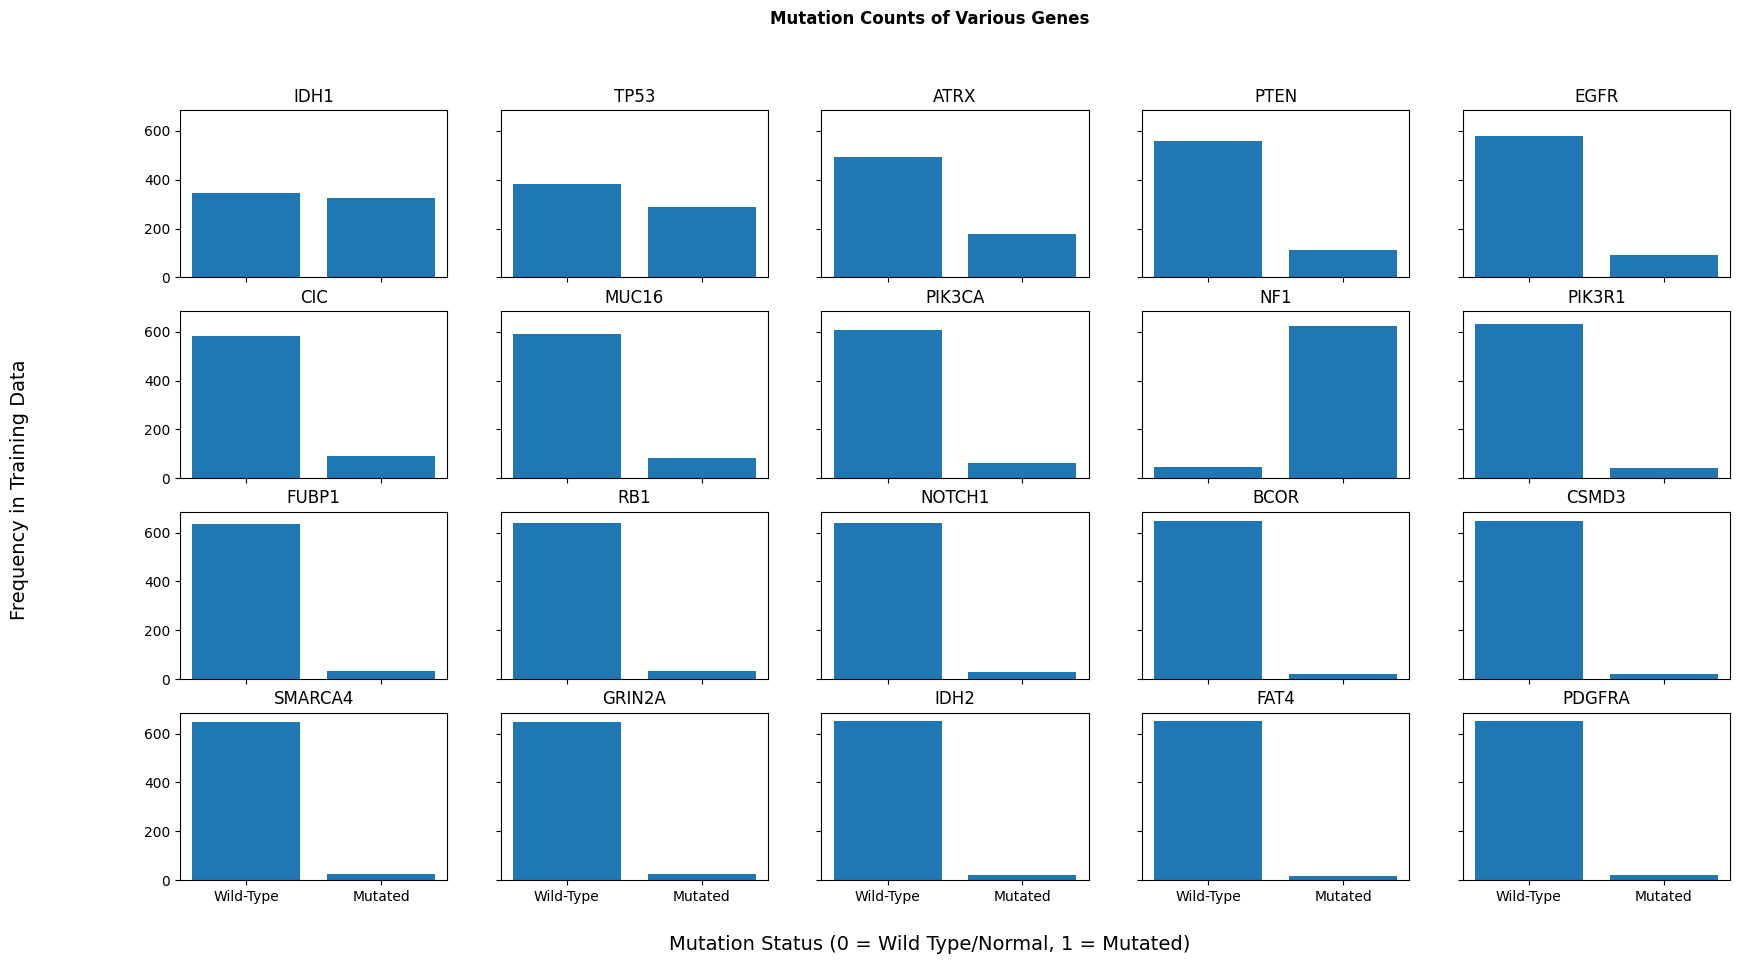

In [ ]:
prop = y.value_counts(normalize = True)
print(f"Size of Dataset: ", y.size)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 0
)

print(y_train.value_counts(normalize = True))
print(f"Size of Dataset: ", y_train.size)

plot_continuous("Age_at_diagnosis", X_train)
plot_categorical("Gender", X_train, levels = ['Male', 'Female'])
plot_categorical("Race", X_train, levels = ['White', 'Black/African American', 'Asian', 'Native American'])
plot_mutation_counts(X_train)

58
42


([<matplotlib.axis.YTick at 0x79a54be3f9a0>,
 [Text(0, 0, 'IDH1'),
  Text(0, 1, 'TP53'),
  Text(0, 2, 'ATRX'),
  Text(0, 3, 'PTEN'),
  Text(0, 4, 'EGFR'),
  Text(0, 5, 'CIC'),
  Text(0, 6, 'MUC16'),
  Text(0, 7, 'PIK3CA'),
  Text(0, 8, 'NF1'),
  Text(0, 9, 'PIK3R1'),
  Text(0, 10, 'FUBP1'),
  Text(0, 11, 'RB1'),
  Text(0, 12, 'NOTCH1'),
  Text(0, 13, 'BCOR'),
  Text(0, 14, 'CSMD3'),
  Text(0, 15, 'SMARCA4'),
  Text(0, 16, 'GRIN2A'),
  Text(0, 17, 'IDH2'),
  Text(0, 18, 'FAT4'),
  Text(0, 19, 'PDGFRA')])

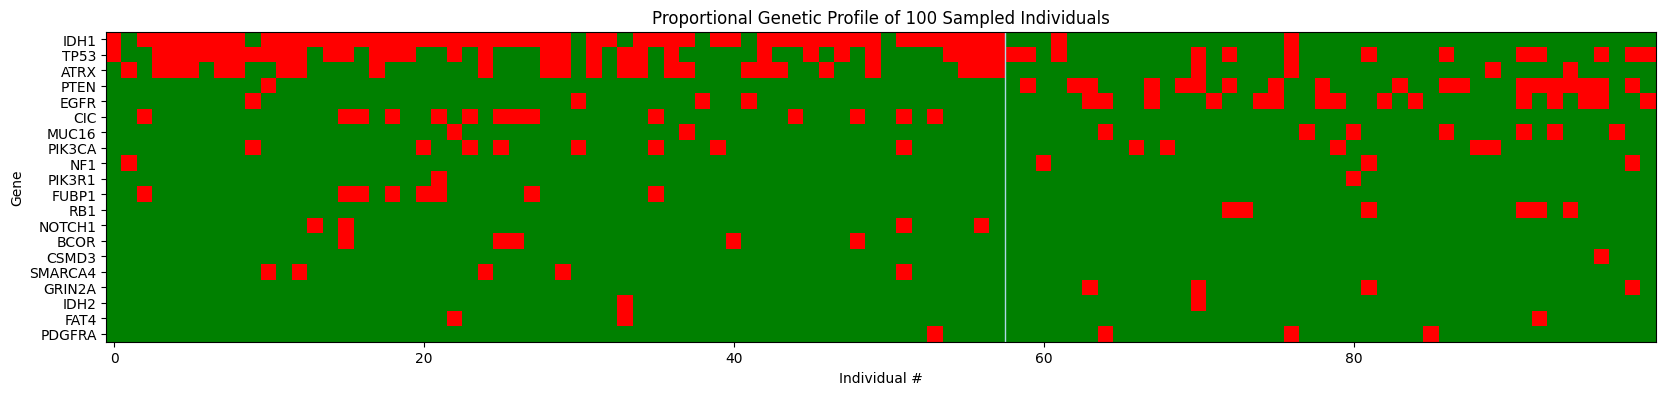

In [ ]:
# Create a custom red-green colormap
red_green_cmap = LinearSegmentedColormap.from_list('RedGreen', ["green", "blue", "red"])

def get_sample_y(tumortype, data_x, data_y):
  mutations = data_x.loc[:, ~data_x.columns.isin(non_genes)]
  prop = data_y.value_counts(normalize = True)
  inst_ttype = np.array(data_y == tumortype).reshape(-1)
  mutations_inst = pd.Series(inst_ttype, index = mutations.index)
  mutation_data = mutations[mutations_inst]
  cnt = round(prop.iloc[tumortype] * 100)
  print(cnt)
  return mutation_data.sample(cnt).to_numpy()

mut = tuple([get_sample_y(i, X_train, y_train) for i in y_test['Grade'].unique()])
plt.figure(figsize = (20, 10))
plt.imshow(np.vstack(mut).T, cmap = red_green_cmap)
plt.axvline(x=57.5, color='lightblue', linestyle='-', linewidth = 1)
plt.title("Proportional Genetic Profile of 100 Sampled Individuals")
plt.xlabel("Individual #")
plt.ylabel("Gene")

x = list(range(20))
xname = X_train.loc[:, ~X_train.columns.isin(non_genes)].columns
plt.yticks(x, xname)

# Preprocessing and Plotting ROC for each dummy model

In [ ]:
X_train, y_train = X_train.reset_index(), y_train.reset_index()
X_test, y_test = X_test.reset_index(), y_test.reset_index()

In [ ]:
encoder = OneHotEncoder(sparse_output = False)
scalar = MinMaxScaler()

def preprocess(X, y):
  ohes = encoder.fit_transform(X['Race'].to_frame())
  age_std = scalar.fit_transform(X['Age_at_diagnosis'].to_frame())

  new_columns = [pd.Series(ohes[:,i], name = grp) \
                for i, grp in enumerate(encoder.categories_[0])]
  race_df = pd.concat(new_columns, axis = 1)
  age_col = pd.Series(age_std.reshape(-1), name = 'Age')
  rem = ['index', 'Race', 'Age_at_diagnosis', 'american indian or alaska native']
  preprocessed_X = pd.concat([X, race_df, age_col], axis = 1)
  for r in rem:
    if r in preprocessed_X.columns:
      preprocessed_X = preprocessed_X.drop(columns = [r])
  return preprocessed_X, y['Grade']

X_train_proc, y_train_proc = preprocess(X_train, y_train)
print(X_train_proc)

     Gender  IDH1  TP53  ATRX  PTEN  EGFR  CIC  MUC16  PIK3CA  NF1  ...  \
0         0     0     0     0     0     0    0      0       0    1  ...   
1         0     1     1     0     0     0    0      1       0    0  ...   
2         0     0     0     0     1     0    0      0       0    1  ...   
3         1     1     1     1     0     0    0      0       0    0  ...   
4         1     1     0     0     0     0    1      0       0    0  ...   
..      ...   ...   ...   ...   ...   ...  ...    ...     ...  ...  ...   
666       1     0     1     0     1     0    0      0       0    0  ...   
667       0     0     1     0     0     1    0      1       1    0  ...   
668       0     1     0     0     0     0    1      0       0    0  ...   
669       1     0     0     0     1     1    0      0       0    0  ...   
670       0     1     0     0     0     0    0      0       0    0  ...   

     CSMD3  SMARCA4  GRIN2A  IDH2  FAT4  PDGFRA  asian  \
0        0        0       0     0     0  

<ipython-input-163-cc74c78f3fc4>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(X_train_proc.columns))


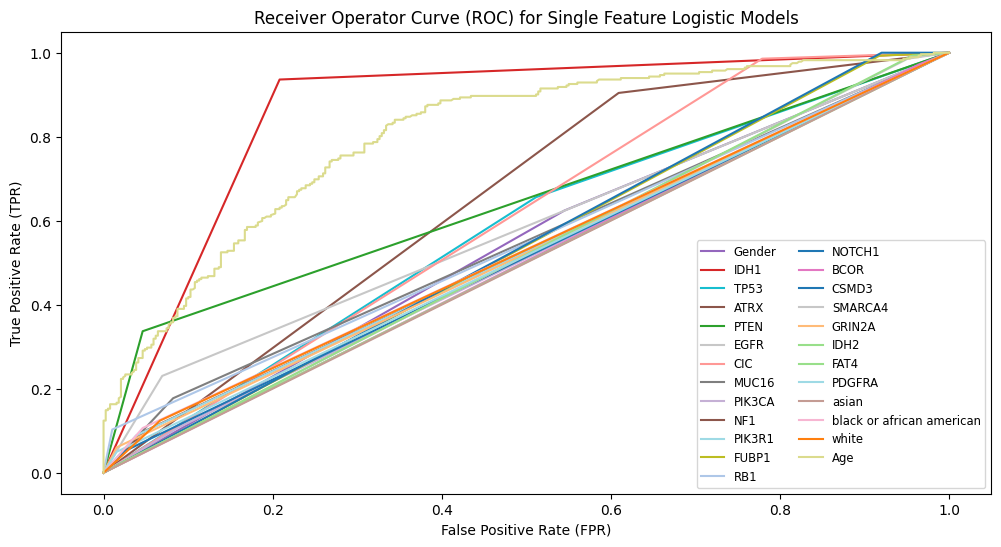

In [ ]:
fprs = {}
tprs = {}

import matplotlib.cm as cm
colormap = cm.get_cmap('tab20', len(X_train_proc.columns))

color = np.array(list(range(len(X_train_proc.columns))))
np.random.shuffle(color)
for column in X_train_proc.columns:
  X_col_train = X_train_proc[column].to_frame()
  dummy_logistical = LogisticRegression()
  dummy_logistical.fit(X_col_train, y_train_proc)
  y_prob = dummy_logistical.predict_proba(X_col_train)[:, 1]
  fpr, tpr, _ = roc_curve(y_train_proc, y_prob)
  fprs[column] = fpr
  tprs[column] = tpr

plt.figure(figsize = (12, 6))
for col, column in enumerate(X_train_proc.columns):
  plt.plot(fprs[column], tprs[column], label = f'{column}', color = colormap(color[col]))
plt.legend(loc = 'lower right', fontsize = 'small', ncol = 2)
plt.title("Receiver Operator Curve (ROC) for Single Feature Logistic Models")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

In [ ]:
X_train_proc.describe()

,Gender,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,asian,black or african american,white,Age
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,...,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,0.421759,0.485842,0.427720,0.266766,0.168405,0.137109,0.134128,0.122206,0.095380,0.070045,...,0.034277,0.034277,0.034277,0.028316,0.026826,0.029806,0.017884,0.071535,0.909091,0.485415
std,0.494209,0.500172,0.495117,0.442599,0.374505,0.344219,0.341044,0.327768,0.293958,0.255413,...,0.182076,0.182076,0.182076,0.165998,0.161694,0.170179,0.132628,0.257909,0.287694,0.209257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.312742
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.491919
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.647856
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model Fitting

Precision - what is the proporition of the observations predicted as glioblastoma multiforme (GBM), that are actually glioblastoma multiforme?

Recall - what is the proportion of observations that are actually glioblastoma multiforme (GBM) that are predicted correctly to be glioblastoma multiforme?

False positive rate - what is the proportion of observations predicted to be glioblastoma multiforme (GBM) that not actually glioblastoma multiforme?

True positive rate - what is the proportion of observations that are glioblastoma multiforme (GBM) that is predicted to be glioblastoma multiforme? (sensitivity)

specificity -  what is the proportion of observations that are lower-grade glioblastoma (LGG) that is that is predicted to be lower-grade glioblastoma? (specificity)

In [ ]:
scoring_metrics = ['f1', 'precision', 'recall', 'balanced_accuracy', 'roc_auc']
get_weight = lambda cat : y_train.value_counts(normalize = True)[cat]
cweight = {k : get_weight(k) for k in np.sort(y_train_proc.unique())}

def generate_results(results, metrics, parameters, logged, evaluation_metric = None):
    means = np.char.add('mean_test_', metrics)
    stdev = np.char.add('std_test_', metrics)
    param_names = np.char.add('param_', list(parameters.keys()))

    model_name_segs = [list(results[str(p)]) for p in param_names]
    metrics_mean = {('Mean ' + m) : pd.Series(results[str(r)]) for r, m in zip(means, metrics)}
    metrics_std = {('Stdev ' + m) : pd.Series(results[str(r)]) for r, m in zip(stdev, metrics)}

    if len(parameters.keys()) == 1:
      plot_results(parameters, metrics_mean, metrics_std, metrics, logged, evaluation_metric)

    metrics_mean.update(metrics_std)
    unlabeled = pd.DataFrame(metrics_mean)
    unlabeled.index = pd.Series([s for s in zip(*model_name_segs)])
    if evaluation_metric != None and evaluation_metric in metrics:
        return unlabeled.sort_values('Mean ' + evaluation_metric, ascending = False)
    return unlabeled

def fit_model(model, data, targs, parameters, scores, logged, cv = 5, best_metric = 'recall'):
    model_gridsearch = GridSearchCV(model, parameters, \
        scoring = scores, refit = best_metric, cv = cv)
    fit = model_gridsearch.fit(data, targs)
    results = generate_results(fit.cv_results_, scores, parameters, logged, evaluation_metric = best_metric)
    print(f"Best Model ({best_metric}: {fit.best_score_}):\n{fit.best_params_}")
    return results, fit.best_params_

def plot_results(parameters, means, stds, metrics, logged, best_metric):
    for par in parameters.keys():
        param_values = parameters[par]
        results = pd.DataFrame(means)
        results_err = pd.DataFrame(stds)
        res = pd.concat((results, results_err), axis = 1)
        res.index = param_values
        logx = False
        if par in logged:
            logx = logged[par]
        res.plot(
          yerr = 'Stdev ' + best_metric,
          y = 'Mean '  + best_metric,
          logx = logx,
          title = f'Model Performance across Hyperparameter {par}',
          xlabel = f'{par}',
          ylabel = "Balanced Accuracy",
          ax = plt.gca()
        )

# Logistic Regression (with LASSO)

Smaller $C$ is more regularization.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best Model (balanced_accuracy: 0.8869724573671942):
{'C': 1}


,Mean f1,Mean precision,Mean recall,Mean balanced_accuracy,Mean roc_auc,Stdev f1,Stdev precision,Stdev recall,Stdev balanced_accuracy,Stdev roc_auc
"(1.0,)",0.867343,0.816667,0.925627,0.886972,0.921452,0.029507,0.035536,0.034116,0.026745,0.019681
"(5.0,)",0.862818,0.820792,0.911341,0.882410,0.918158,0.023907,0.041401,0.029592,0.021184,0.020140
"(0.5,)",0.861882,0.804245,0.929135,0.882317,0.919370,0.029027,0.030474,0.036956,0.026717,0.021505
"(10.0,)",0.860975,0.820263,0.907832,0.880656,0.916784,0.022416,0.041287,0.025925,0.019785,0.020736
"(50.0,)",0.858980,0.819874,0.904261,0.878870,0.915319,0.019779,0.040603,0.028812,0.017512,0.021087
"(100.0,)",0.858980,0.819874,0.904261,0.878870,0.915271,0.019779,0.040603,0.028812,0.017512,0.021120
"(0.025,)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906
"(0.05,)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906
"(0.1,)",0.842360,0.766118,0.936216,0.864012,0.882058,0.026210,0.031438,0.028589,0.024906,0.016013
"(0.01,)",0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


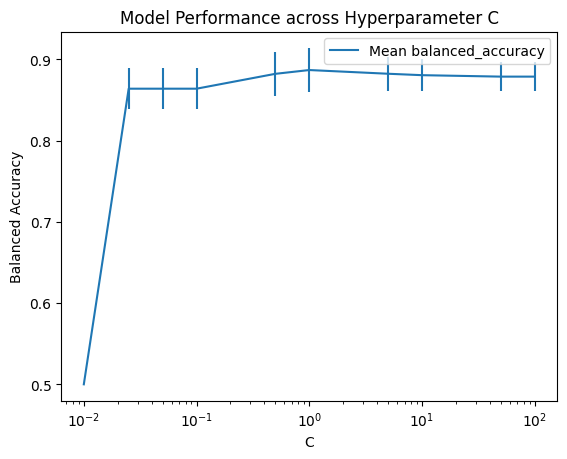

In [ ]:
logistic_regression_hyperparameters = {
    'C' : [0.01, 0.025, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
}
logged_lrl = {'C' : True}

logregr_lasso = LogisticRegression(penalty = 'l1', \
                                   random_state = 0, solver = 'saga')

result_logregr, best_logregr = \
  fit_model(logregr_lasso, X_train_proc, y_train_proc,
            logistic_regression_hyperparameters, scoring_metrics,
            logged_lrl, cv = 5, best_metric = 'balanced_accuracy')
result_logregr

# Decision Trees

Best Model (balanced_accuracy: 0.8843770264822896):
{'max_depth': 4}


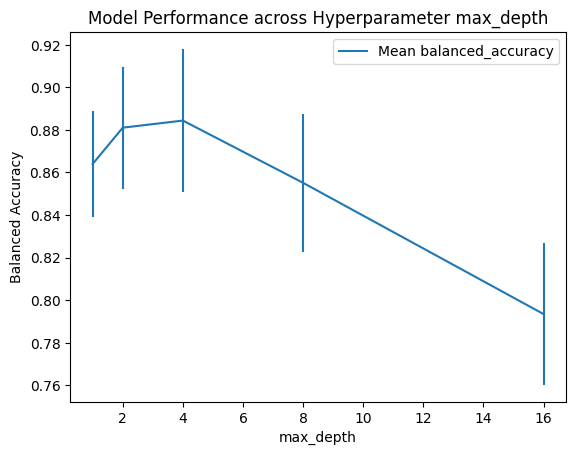

Best Model (balanced_accuracy: 0.8830949752002384):
{'max_leaf_nodes': 4}


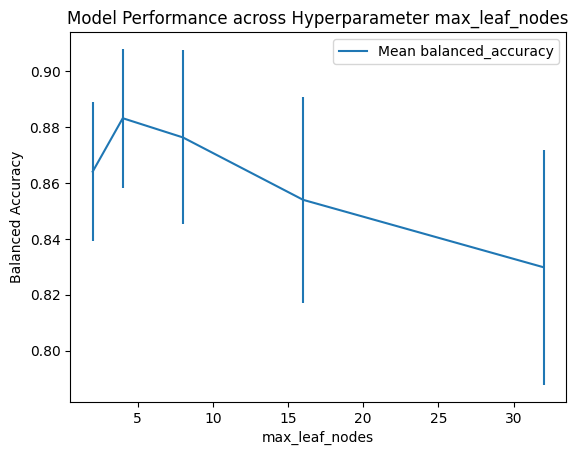

Best Model (balanced_accuracy: 0.8823165869218501):
{'ccp_alpha': 0.01}


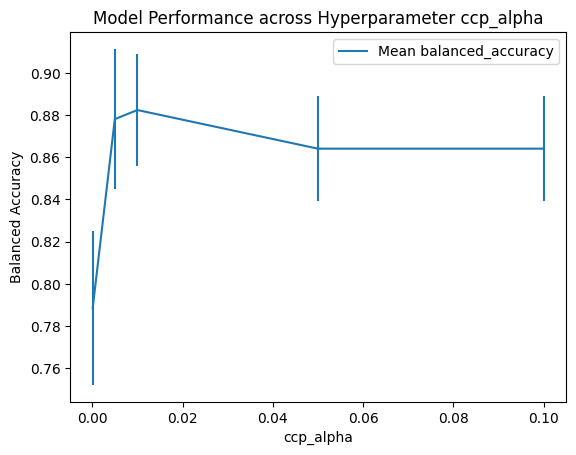

Best Model (balanced_accuracy: 0.8874447920500552):
{'ccp_alpha': 0.0001, 'max_depth': 4, 'max_leaf_nodes': 16}
{'ccp_alpha': 0.0001, 'max_depth': 4, 'max_leaf_nodes': 16}


In [ ]:
from sklearn.tree import DecisionTreeClassifier

parameter_grid_dt = {
    'max_depth':      [1, 2, 4, 8, 16],
    'max_leaf_nodes': [2, 4, 8, 16, 32],
    "ccp_alpha":      [0.0001, 0.005, 0.01, 0.05, 0.1]
}

logged_dt = {}

dt_classifer = DecisionTreeClassifier(random_state=0)


for param in parameter_grid_dt.keys():
  fit_model(dt_classifer, X_train_proc, y_train_proc,
            {param : parameter_grid_dt[param]}, scoring_metrics, logged_dt,
            cv = 5, best_metric = 'balanced_accuracy')
  plt.show()

result_dt, best_dt = fit_model(dt_classifer, X_train_proc, y_train_proc,
          parameter_grid_dt, scoring_metrics, logged_dt,
          cv = 5, best_metric = 'balanced_accuracy')

print(best_dt)

In [ ]:
result_dt

,Mean f1,Mean precision,Mean recall,Mean balanced_accuracy,Mean roc_auc,Stdev f1,Stdev precision,Stdev recall,Stdev balanced_accuracy,Stdev roc_auc
"(4, 16, 0.0001)",0.867843,0.814763,0.929135,0.887445,0.900785,0.033750,0.038404,0.036956,0.031184,0.034623
"(4, 32, 0.0001)",0.867843,0.814763,0.929135,0.887445,0.900785,0.033750,0.038404,0.036956,0.031184,0.034623
"(4, 32, 0.005)",0.865343,0.816106,0.921992,0.885155,0.900288,0.029654,0.034170,0.038083,0.027179,0.029965
"(4, 16, 0.005)",0.865343,0.816106,0.921992,0.885155,0.900288,0.029654,0.034170,0.038083,0.027179,0.029965
"(4, 8, 0.005)",0.865343,0.816106,0.921992,0.885155,0.900288,0.029654,0.034170,0.038083,0.027179,0.029965
...,...,...,...,...,...,...,...,...,...,...
"(1, 32, 0.01)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906
"(1, 16, 0.01)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906
"(8, 32, 0.0001)",0.835622,0.788566,0.890163,0.857686,0.859484,0.036487,0.043879,0.042106,0.033595,0.038771
"(16, 16, 0.0001)",0.829856,0.811713,0.854323,0.853902,0.871169,0.041230,0.044750,0.078501,0.036887,0.045767


Logistic Regression (with LASSO)

 - Regularization Parameter [0.01, 0.1, 0.25, 0.5, 1, 5, 10, 100]

Decision Trees:
 - max_depth      [1, 2, 4, 8, 16]
 - max_leaf_nodes [2, 4, 8, 16, 32]
 - ccp_alpha      [0.0001, 0.005, 0.01, 0.05, 0.1]

Adaboost:
 - learning rate  [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
 - n_estimators   [1, 2, 4, 8, 16, 32, 64, 128, 256]

Random Forest:
 - max_features.  [1, 5, 10, 15, 20, 25, 30]
 - n_estimators   [1, 2, 4, 8, 16, 32, 64, 128, 256]
 - max_samples    [n, n // 2, n // 4, n // 8, n // 16

GOSDT:
 - maxdepth       [1, 2, 4]
 - learning_rate  [0.05, 0.1, 0.5, 1]

Best Model (balanced_accuracy: 0.882788921604711):
{'learning_rate': 0.5}


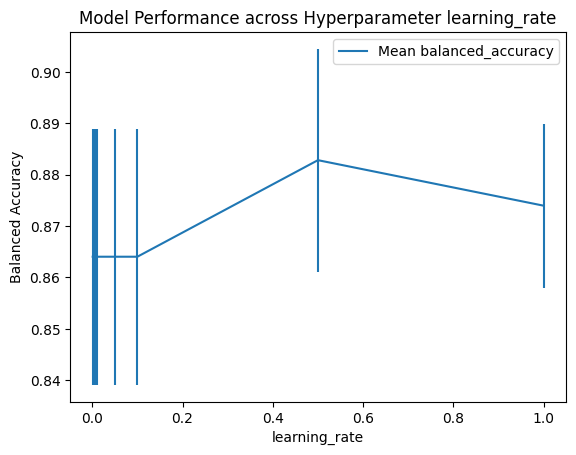

Best Model (balanced_accuracy: 0.8821982841719684):
{'n_estimators': 256}


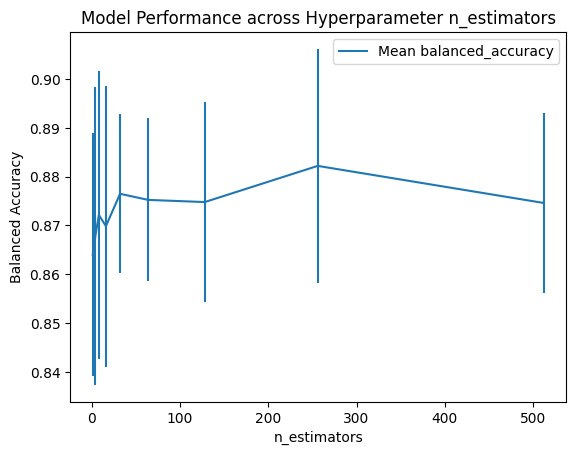

Best Model (balanced_accuracy: 0.882788921604711):
{'learning_rate': 0.1, 'n_estimators': 512}
{'learning_rate': 0.1, 'n_estimators': 512}


In [ ]:
import copy

adaboost_paramgrid = {
  'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
  'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
}

adaboost_logged = {}
adaboost_classifier = AdaBoostClassifier(random_state=0, algorithm = 'SAMME')

for param in adaboost_paramgrid.keys():
  fit_model(adaboost_classifier, X_train_proc, y_train_proc,
            {param : adaboost_paramgrid[param]}, scoring_metrics, adaboost_logged,
            cv = 5, best_metric = 'balanced_accuracy')
  plt.show()

result_ada, best_ada = fit_model(adaboost_classifier, X_train_proc, y_train_proc,
          adaboost_paramgrid, scoring_metrics, adaboost_logged,
          cv = 5, best_metric = 'balanced_accuracy')

print(best_ada)


In [ ]:
result_ada

,Mean f1,Mean precision,Mean recall,Mean balanced_accuracy,Mean roc_auc,Stdev f1,Stdev precision,Stdev recall,Stdev balanced_accuracy,Stdev roc_auc
"(0.1, 512)",0.862200,0.801903,0.932644,0.882789,0.911408,0.023263,0.020141,0.032411,0.021663,0.019978
"(0.5, 32)",0.862464,0.802638,0.932644,0.882789,0.910043,0.028192,0.032428,0.032411,0.026020,0.022038
"(0.5, 64)",0.862200,0.801903,0.932644,0.882789,0.914396,0.023263,0.020141,0.032411,0.021663,0.022676
"(1.0, 256)",0.862111,0.812912,0.918609,0.882198,0.914766,0.026214,0.032397,0.032492,0.023969,0.016637
"(0.05, 512)",0.860954,0.799924,0.932644,0.881507,0.909614,0.026376,0.028243,0.032411,0.024489,0.018692
...,...,...,...,...,...,...,...,...,...,...
"(0.01, 512)",0.842360,0.766118,0.936216,0.864012,0.896118,0.026210,0.031438,0.028589,0.024906,0.024202
"(0.05, 1)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906
"(0.05, 2)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906
"(0.05, 4)",0.842360,0.766118,0.936216,0.864012,0.864012,0.026210,0.031438,0.028589,0.024906,0.024906


Best Model (balanced_accuracy: 0.8551093643198907):
{'max_features': 5}


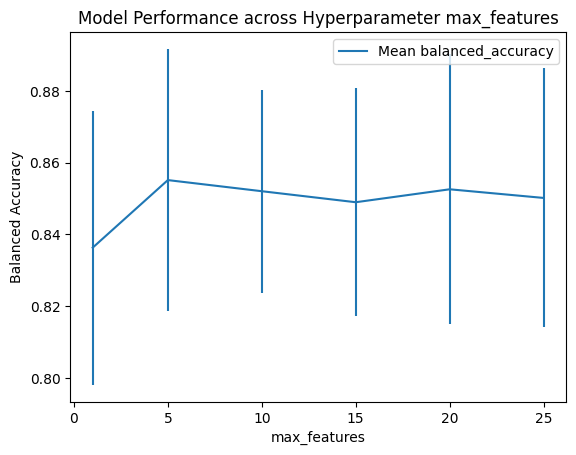

Best Model (balanced_accuracy: 0.8803812415654519):
{'max_samples': 41}


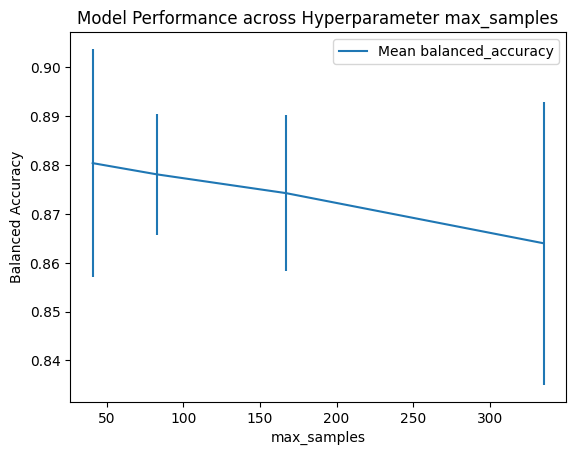

Best Model (balanced_accuracy: 0.8563600872811399):
{'n_estimators': 64}


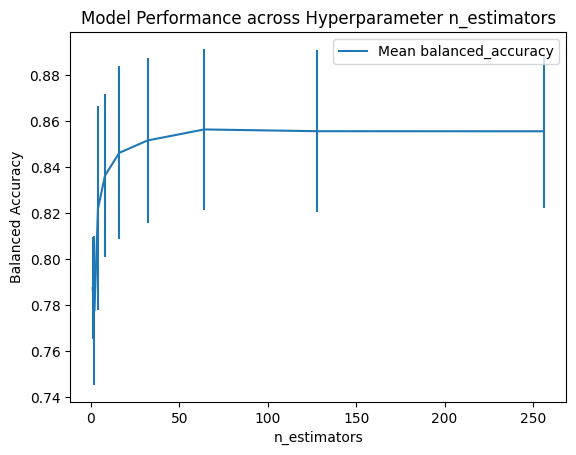

Best Model (balanced_accuracy: 0.8838880417827786):
{'max_depth': 4}


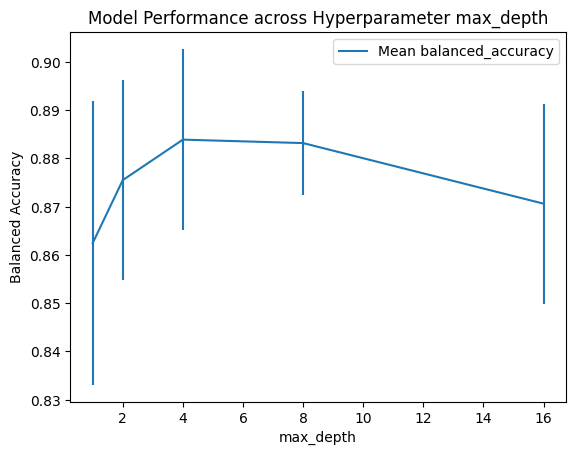

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Best Model (balanced_accuracy: 0.8911266365213735):
{'max_depth': 8, 'max_features': 25, 'max_samples': 167, 'n_estimators': 128}


In [ ]:
import copy

parameter_grid_rf = {}
n, p = X_train_proc.shape

parameter_grid_rf['max_features'] = [1, 5, 10, 15, 20, 25]
parameter_grid_rf['max_samples'] = [n // 2, n // 4, n // 8, n // 16]
parameter_grid_rf['n_estimators'] = [1, 2, 4, 8, 16, 32, 64, 128, 256]
parameter_grid_rf['max_depth'] = [1, 2, 4, 8, 16]

rf_logged = {}
rf_classifier = RandomForestClassifier(random_state=0)

for param in parameter_grid_rf.keys():
  fit_model(rf_classifier, X_train_proc, y_train_proc,
            {param : parameter_grid_rf[param]}, scoring_metrics, rf_logged,
            cv = 5, best_metric = 'balanced_accuracy')
  plt.show()

result_rf, best_rf = fit_model(rf_classifier, X_train_proc, y_train_proc,
          parameter_grid_rf, scoring_metrics, rf_logged,
          cv = 5, best_metric = 'balanced_accuracy')

In [ ]:

parameter_grid_rf

{'max_features': [1, 5, 10, 15, 20, 25],
 'max_samples': [335, 167, 83, 41],
 'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256],
 'max_depth': [1, 2, 4, 8, 16]}

In [ ]:
result_rf

,Mean f1,Mean precision,Mean recall,Mean balanced_accuracy,Mean roc_auc,Stdev f1,Stdev precision,Stdev recall,Stdev balanced_accuracy,Stdev roc_auc
"(25, 167, 128, 8)",0.872302,0.831606,0.918484,0.891127,0.910306,0.030165,0.038883,0.036413,0.027110,0.023250
"(25, 167, 256, 8)",0.872217,0.831490,0.918484,0.891110,0.911794,0.027286,0.035546,0.036413,0.024443,0.023878
"(20, 83, 256, 8)",0.870838,0.829320,0.918421,0.889797,0.913823,0.023788,0.036950,0.033007,0.021330,0.018175
"(20, 167, 256, 8)",0.870377,0.831243,0.914912,0.889341,0.911037,0.027764,0.038279,0.036123,0.024976,0.020440
"(15, 335, 256, 8)",0.870409,0.831511,0.914912,0.889324,0.915310,0.025949,0.038351,0.036123,0.023434,0.016251
...,...,...,...,...,...,...,...,...,...,...
"(1, 335, 256, 1)",0.007018,0.200000,0.003571,0.501786,0.894419,0.014035,0.400000,0.007143,0.003571,0.027799
"(1, 83, 256, 1)",0.007018,0.200000,0.003571,0.501786,0.894952,0.014035,0.400000,0.007143,0.003571,0.028420
"(1, 167, 256, 1)",0.007018,0.200000,0.003571,0.501786,0.894774,0.014035,0.400000,0.007143,0.003571,0.028888
"(1, 335, 64, 1)",0.013676,0.166667,0.007143,0.499725,0.882026,0.016751,0.210819,0.008748,0.002055,0.027306


0.8530612244897959
0.8530612244897959
0.8459183673469388
0.8622448979591837


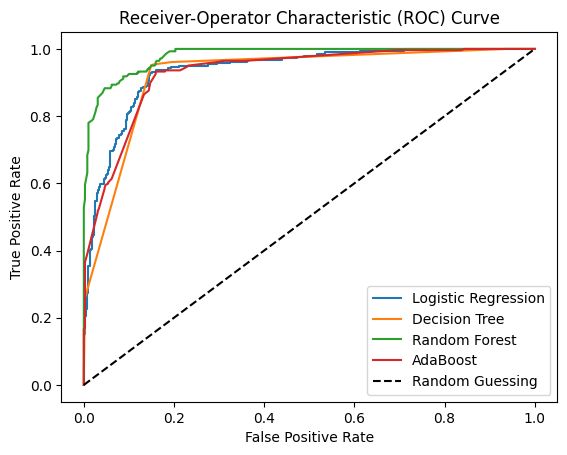

In [ ]:
def evaluate(model, Xtrain, Xtest, ytrain, ytest):
  model.fit(Xtrain, ytrain)
  best_trainpred = model.predict(Xtrain)
  best_testpred = model.predict(Xtest)

  probs = model.predict_proba(Xtrain)[:,1]
  fpr, tpr, threshold = roc_curve(y_score = probs, y_true = ytrain)
  results = {
      'train' : {
          'bal_acc' : balanced_accuracy_score(ytrain, best_trainpred),
          'recall' : recall_score(ytrain, best_trainpred),
          'precision' : precision_score(ytrain, best_trainpred),
          'roc_auc' : roc_auc_score(ytrain, best_trainpred),
          'f1' : f1_score(ytrain, best_trainpred)
      },
      'test' : {
          'bal_acc' : balanced_accuracy_score(ytest, best_testpred),
          'recall' : recall_score(ytest, best_testpred),
          'precision' : precision_score(ytest, best_testpred),
          'roc_auc' : roc_auc_score(ytest, best_testpred),
          'f1' : f1_score(ytest, best_testpred)
      },
      'fpr' : fpr,
      'tpr' : tpr,
      'thresholds' : threshold
  }
  return results

X_test_proc, y_test_proc = preprocess(X_test, y_test)

best_logreg = LogisticRegression(random_state = 0, solver = 'saga', \
                                 penalty = 'l1', C = best_logregr['C'])
best_dtree = DecisionTreeClassifier(random_state = 0, max_depth = best_dt['max_depth'],
                                 max_leaf_nodes = best_dt['max_leaf_nodes'],
                                 ccp_alpha = best_dt['ccp_alpha'])
best_rforest = RandomForestClassifier(random_state=0,
                                      max_features = best_rf['max_features'],
                                      max_samples = best_rf['max_samples'],
                                      n_estimators = best_rf['n_estimators'])
best_adaboost = AdaBoostClassifier(random_state = 0, algorithm = 'SAMME',
                                   learning_rate = best_ada['learning_rate'],
                                   n_estimators = best_ada['n_estimators'])

logistic_results = evaluate(best_logreg, X_train_proc, X_test_proc, y_train_proc, y_test_proc)
dt_results = evaluate(best_dtree, X_train_proc, X_test_proc, y_train_proc, y_test_proc)
rf_results = evaluate(best_rforest, X_train_proc, X_test_proc, y_train_proc, y_test_proc)
ada_results = evaluate(best_adaboost, X_train_proc, X_test_proc, y_train_proc, y_test_proc)

plt.plot(logistic_results['fpr'], logistic_results['tpr'], label = 'Logistic Regression')
plt.plot(dt_results['fpr'], dt_results['tpr'], label = 'Decision Tree')
plt.plot(rf_results['fpr'], rf_results['tpr'], label = 'Random Forest')
plt.plot(ada_results['fpr'], ada_results['tpr'], label = 'AdaBoost')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.title("Receiver-Operator Characteristic (ROC) Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

print(logistic_results['test']['bal_acc'])
print(dt_results['test']['bal_acc'])
print(rf_results['test']['bal_acc'])
print(ada_results['test']['bal_acc'])

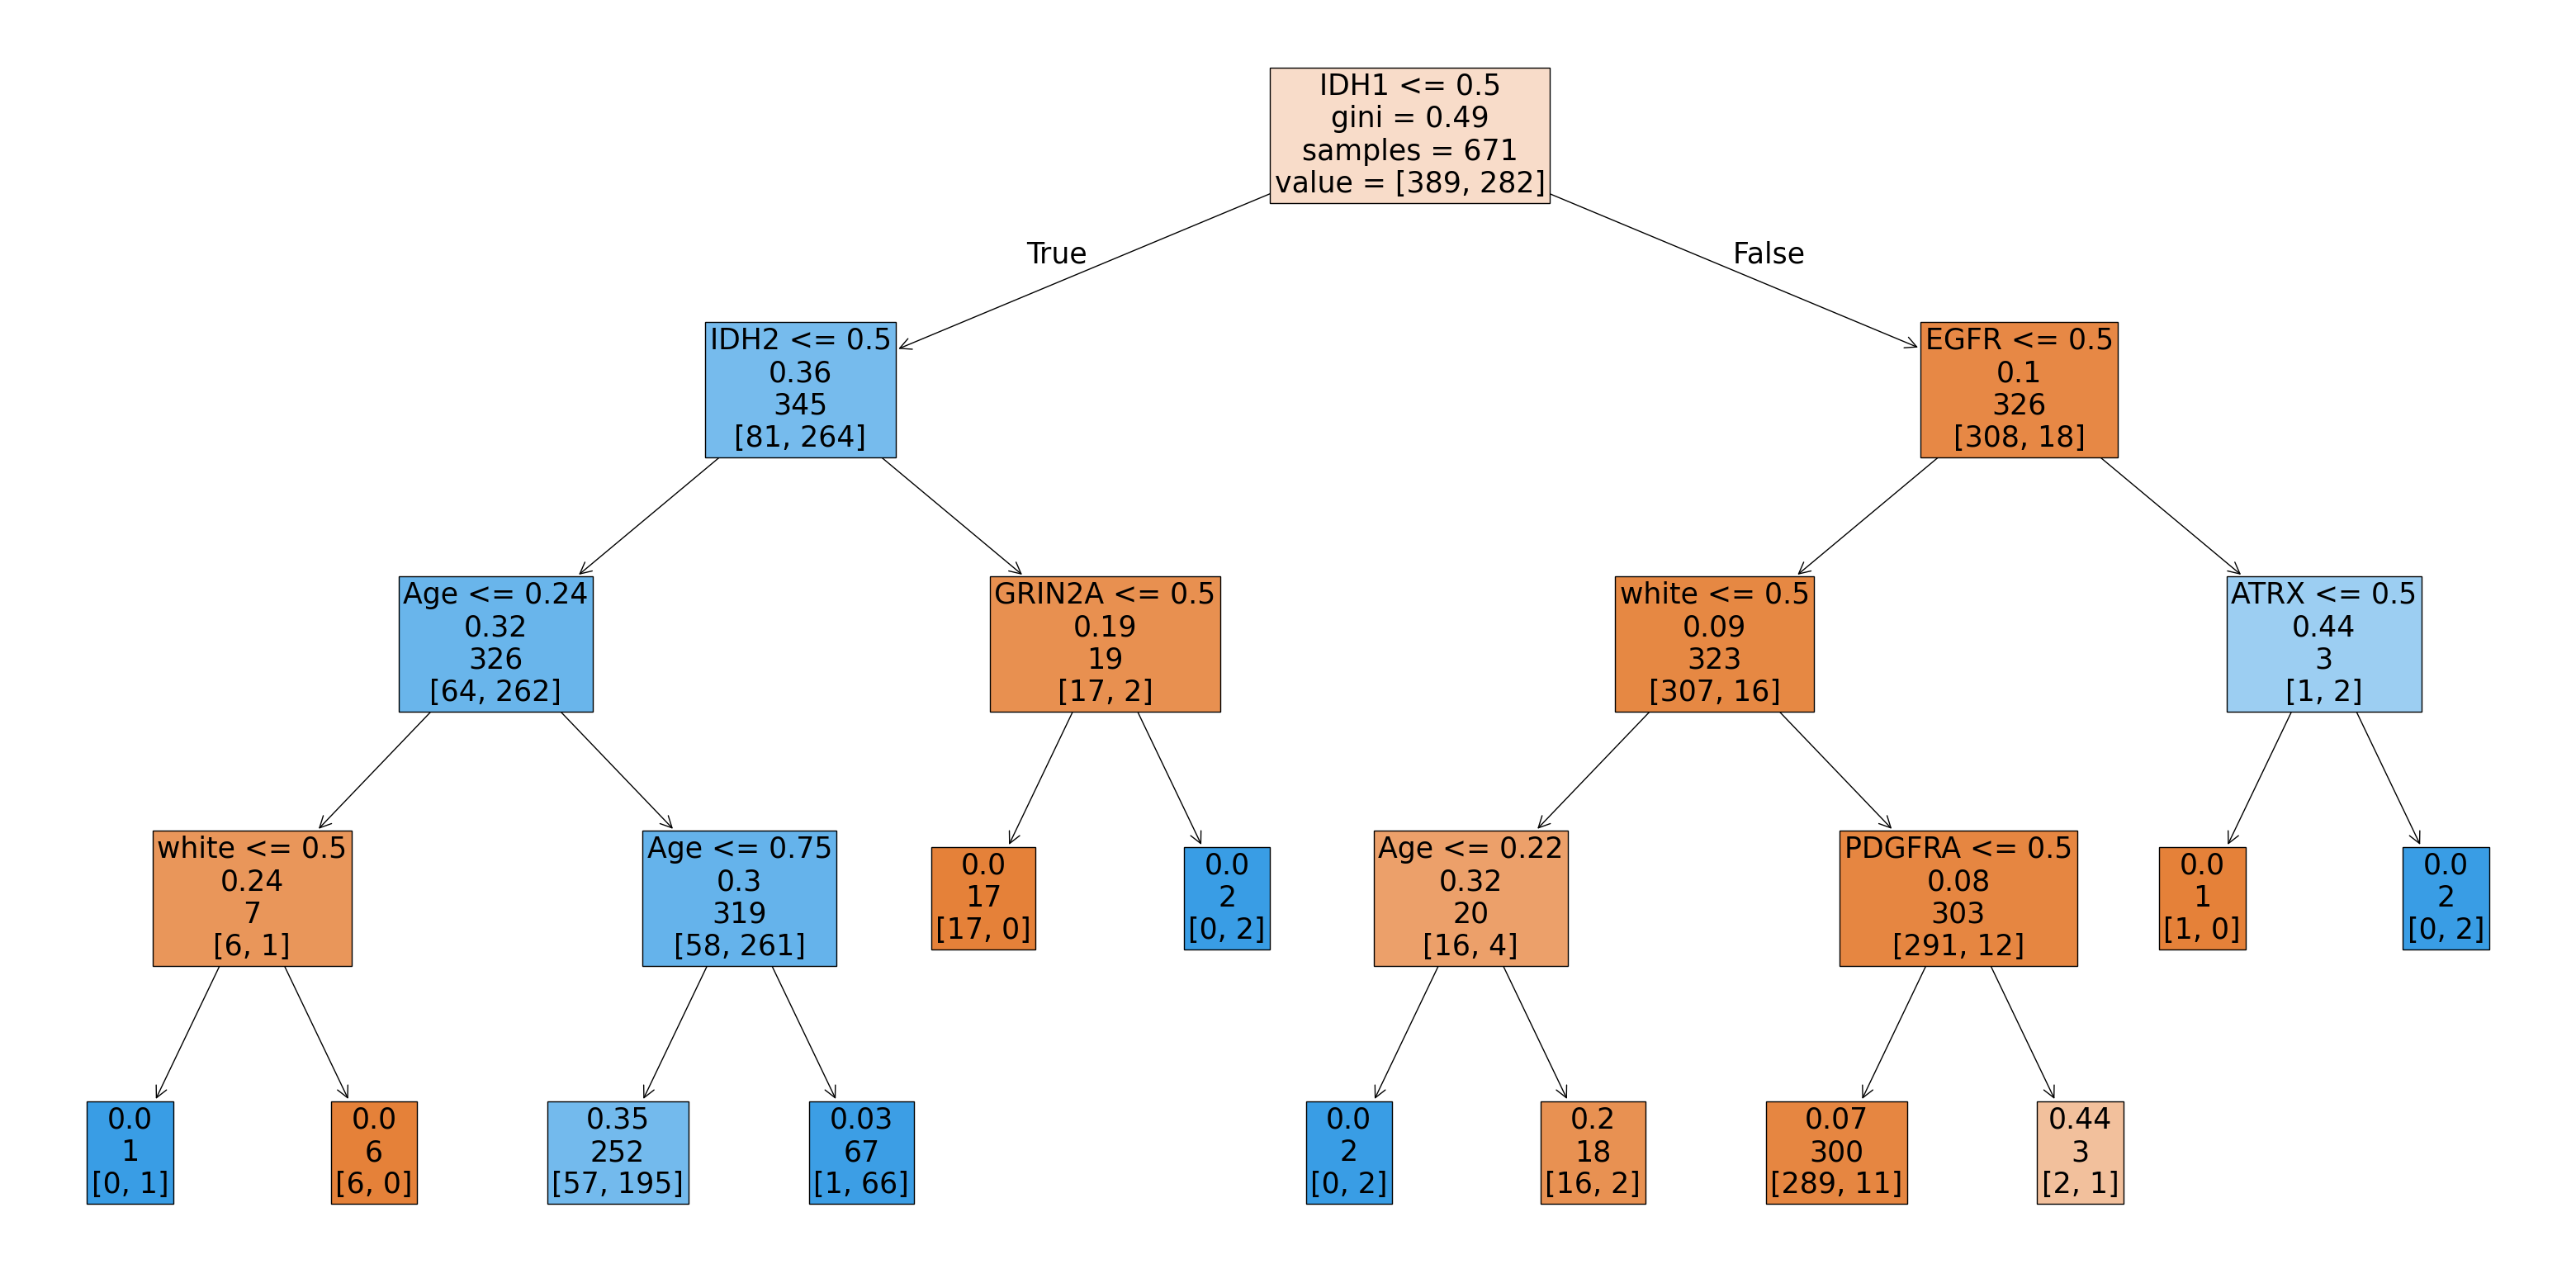

In [ ]:
plt.figure(figsize=(40, 20))  # set plot size (denoted in inches)
plot_tree(best_dtree, feature_names = X_train_proc.columns, label = 'root', \
          filled = True, precision = 2, fontsize = 25)
plt.show()

In [ ]:
coefs = pd.DataFrame(pd.Series(best_logreg.coef_[0], name = 'coef'))
coefs.index = X_train_proc.columns
coefs.sort_values(by = 'coef')

,coef
IDH1,-4.009983
IDH2,-2.629868
NOTCH1,-1.738404
NF1,-0.861426
EGFR,-0.596437
CIC,-0.539365
SMARCA4,-0.286241
Gender,-0.171883
asian,0.000000
ATRX,0.000000


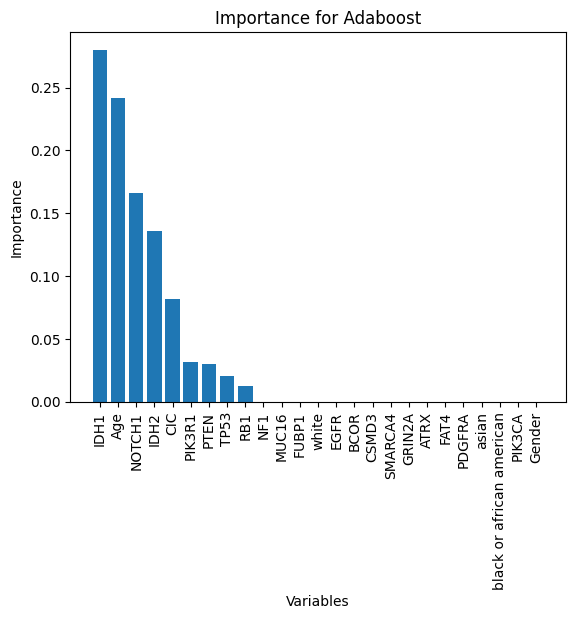

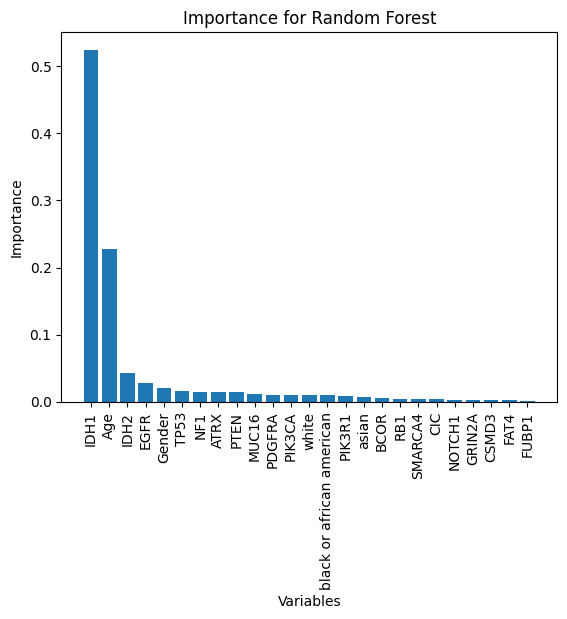

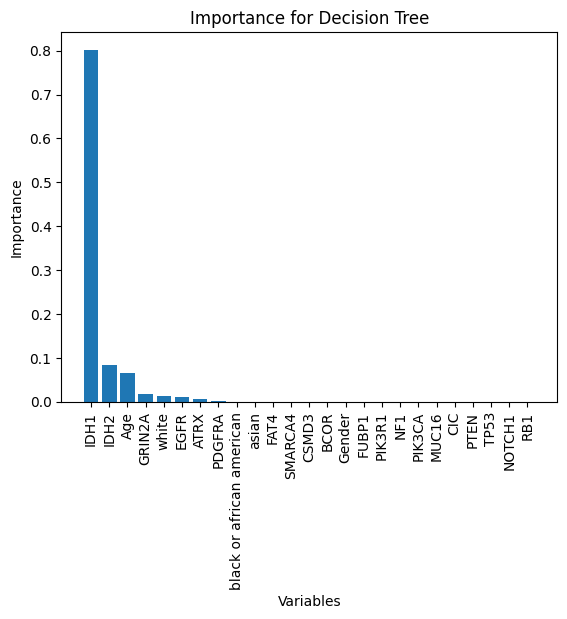

In [ ]:
def gini_importance(model, Xtrain):
  varimp = model.feature_importances_
  ordered = np.argsort(-varimp)
  x = X_train_proc.columns[ordered]
  y = varimp[ordered]
  return x, y

def plot_variable_importance(model, model_name, Xtrain, importance_function):
  var, varimportance = importance_function(model, Xtrain)
  plt.bar(x = var, height = varimportance)
  plt.xticks(rotation = 90)
  plt.xlabel(xlabel = 'Variables')
  plt.ylabel(ylabel = 'Importance')
  plt.title(label = f'Importance for {model_name}')
  plt.show()

plot_variable_importance(best_adaboost, 'Adaboost', X_train_proc, gini_importance)
plot_variable_importance(best_rforest, 'Random Forest', X_train_proc, gini_importance)
plot_variable_importance(best_dtree, 'Decision Tree', X_train_proc, gini_importance)

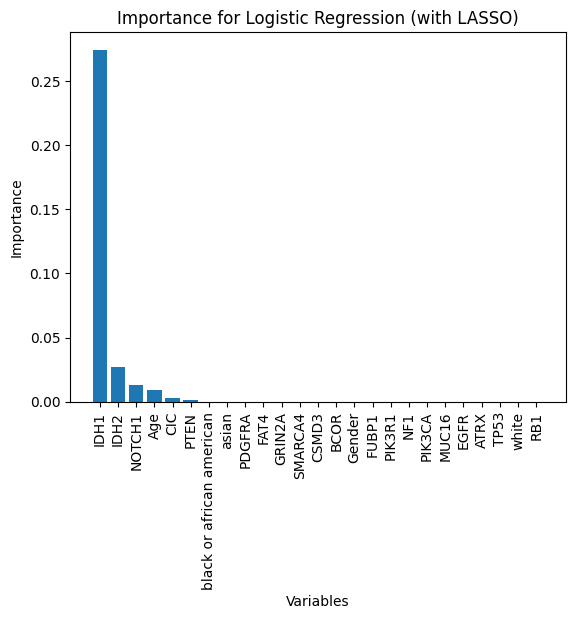

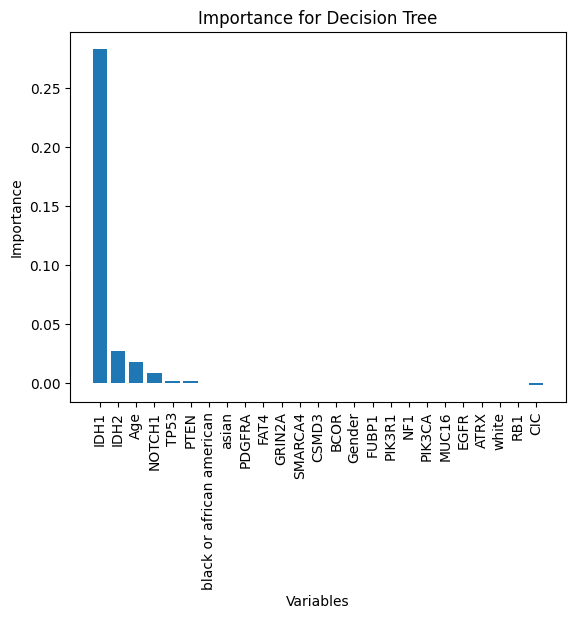

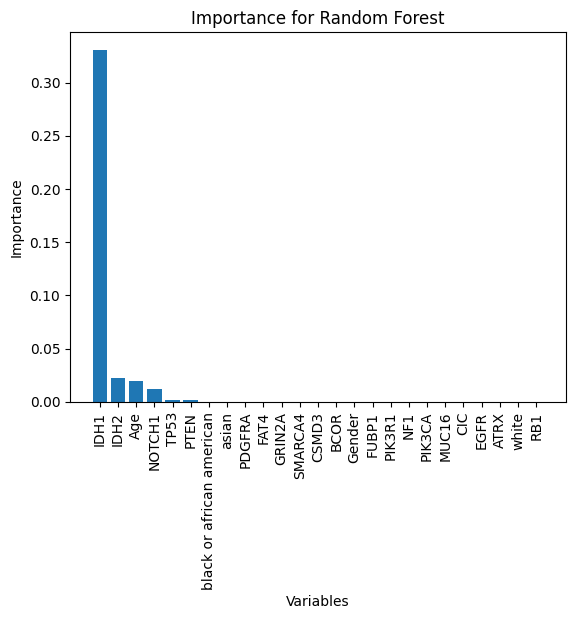

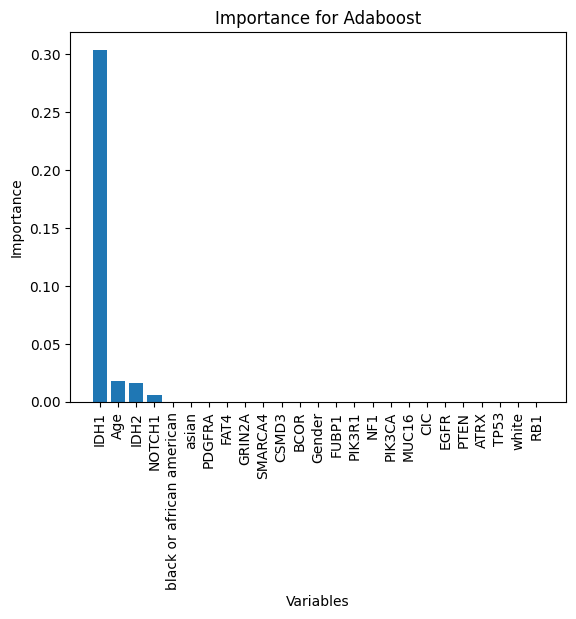

In [ ]:
nrow, ncol = X_train_proc.shape
np.random.seed(0)

def calc_permutation_varimp(col):
  original = X_train_proc[col]
  X_train_proc[col] = np.random.permutation(original)
  new = best_adaboost.score(X_train_proc, y_train_proc)
  X_train_proc[col] = original
  og = best_adaboost.score(X_train_proc, y_train_proc)
  return og - new

def permutation_importance(model, Xtrain):
  varimp = np.array([calc_permutation_varimp(col) for col in Xtrain.columns])
  ordered = np.argsort(-varimp)
  x = X_train_proc.columns[ordered]
  y = varimp[ordered]
  return x, y

plot_variable_importance(best_logreg, 'Logistic Regression (with LASSO)',
                         X_train_proc, permutation_importance)
plot_variable_importance(best_dtree, 'Decision Tree', X_train_proc,
                         permutation_importance)
plot_variable_importance(best_rforest, 'Random Forest', X_train_proc,
                         permutation_importance)
plot_variable_importance(best_adaboost, 'Adaboost', X_train_proc,
                         permutation_importance)


# FastSparseGAMs

In [ ]:
# This code is pulled straight from the l0learn/fastsparsegams package.
# We'll use this to setup our binary data for fastsparsegams.
def convert_continuous_df_to_binary_df(df):
    """Convert continuous features to binary features in the dataframe.

    Generates 100 percentile thresholds for each feature.

    Parameters:
        df (pandas.DataFrame): The input dataframe containing continuous features.

    Returns:
        pandas.DataFrame: The binary dataframe with converted features.
    """
    colnames = df.columns
    n = len(df)
    print("Make sure your first column corresponds to the y label")
    print("Converting continuous features to binary features in the dataframe......")

    percentile_ticks = range(1, 101)

    binarized_dict = {}

    for i in range(0, len(colnames)):
        uni = df[colnames[i]].unique()
        if len(uni) == 2:
            binarized_dict[colnames[i] + '<=0.5'] = np.asarray(1 - df[colnames[i]], dtype=int)
            continue

        uni.sort()
        if len(uni) >= 100:
            uni = np.percentile(uni, percentile_ticks)
        for j in range(len(uni) - 1):
            tmp_feature = np.ones(n, dtype=int)
            tmp_name = colnames[i] + "<=" + str(uni[j])

            zero_indices = df[colnames[i]] > uni[j]
            tmp_feature[zero_indices] = 0

            binarized_dict[tmp_name] = tmp_feature

    binarized_df = pd.DataFrame(binarized_dict)
    print("Finish converting continuous features to binary features......")
    return binarized_df


def convert_coefficients_to_shape_function(coefficients, direction="<"):
    """Convert the gam feature coefficients to a step/shape function.

    This is needed to make the coefficient representation conform to the
    alignment expectations of plt.step, which are somewhat unintuitive.
    You can figure out how to do this yourself with a whiteboard and some patience,
    but I did that for you :)

    Parameters:
        coefficients (list[float]): The coefficients of the shape function.
        direction (str, optional): The direction of the step function.
            Can be "<" or ">". Defaults to "<".

    Returns:
        list[float]: The step function coefficients.
    """
    coefficients_steps = np.zeros(len(coefficients)+2)
    if direction == "<":
        coeff_reverse_cumsum = np.cumsum(coefficients[::-1])[::-1]
        coefficients_steps[1:-1] = coeff_reverse_cumsum
        coefficients_steps[0] = coeff_reverse_cumsum[0]
    else:
        coeff_cumsum = np.cumsum(coefficients)
        coefficients_steps[2:] = coeff_cumsum
    return coefficients_steps


def plot_shape_function(steps: list[float], coefficients: list[float], feature_name: str, ax=None):
    """Plot the shape function of the GAM for a single feature.

    The shape function is a piecewise constant function that is the sum of the coefficients
    where the feature value is less than or equal to the step (or greater than).

    Parameters:
        steps (list[float]): The steps in the shape function. Assume these are sorted in ascending order.
        coefficients (list[float]): The coefficients of the shape function.
        feature_name (str): The name of the feature.
        ax (matplotlib.axes.Axes, optional): The axes on which to plot the shape function.
            If not provided, a new figure and axes will be created.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()
    ax.step(steps, coefficients, where="pre")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Shape function")
    ax.set_title(f"Shape function for {feature_name}")
    plt.show()

def plot_shape_functions_fastsparse(gam, binary_cols, continuous_df, lambda_0=0):
    """Plot the shape functions of a GAM model using the fastsparse package.

    Parameters:
        gam: The trained GAM model.
        binary_cols: The binary column names used in the GAM model.
        continuous_df: The continuous dataframe used in the GAM model.
        lambda_0 (float, optional): The regularization parameter. Defaults to 0.

    Returns:
        None
    """
    gam_coeffs = gam.coeff(lambda_0=lambda_0)
    intercept = gam_coeffs[0]
    coefficients = gam_coeffs[1:]
    used_binary_features = binary_cols[coefficients.indices]  # of form "feature_name<=threshold"
    feature_names = np.unique([feature.split("<=")[0] for feature in used_binary_features])
    for feature_name in feature_names:
        feature_indices = []
        for i, feature in enumerate(used_binary_features):
            if feature_name in feature:
                feature_indices.append(i)

        feature_min = continuous_df[feature_name].min()
        feature_max = continuous_df[feature_name].max()
        steps = [float(feature.split("<=")[1]) for feature in used_binary_features[feature_indices]]
        steps = [feature_min] + steps + [feature_max]

        coefficients_lte = gam_coeffs.data[feature_indices]
        coefficients_lte_steps = convert_coefficients_to_shape_function(coefficients_lte, direction="<")
        coefficients = coefficients_lte_steps
        print(steps, coefficients, feature_name)
        plot_shape_function(steps, coefficients, feature_name)

In [ ]:
train_binary_df = convert_continuous_df_to_binary_df(pd.concat([y_train_proc, X_train_proc], axis=1))
X_train_binary = train_binary_df[train_binary_df.columns[1:]]
y_train_binary = train_binary_df[train_binary_df.columns[0]]

test_binary_df = convert_continuous_df_to_binary_df(pd.concat([y_test_proc, X_test_proc], axis=1))
X_test_binary = test_binary_df[test_binary_df.columns[1:]]
y_test_binary = test_binary_df[test_binary_df.columns[0]]

# make sure the datatypes are correct to pass into fastsparsegams
X_train_fsg = X_train_binary.values.astype(float)
y_train_fsg = y_train_binary.values

models = fsg.fit(X_train_fsg, y_train_fsg, loss = 'Logistic', \
                 algorithm = 'CDPSI', max_support_size = 50)

possible_lambdas = models.lambda_0[0]

Make sure your first column corresponds to the y label
Converting continuous features to binary features in the dataframe......
Finish converting continuous features to binary features......
Make sure your first column corresponds to the y label
Converting continuous features to binary features in the dataframe......
Finish converting continuous features to binary features......


In [ ]:
print([round(l, 3) for l in possible_lambdas])

[168.991, 167.301, 78.474, 62.779, 50.223, 40.179, 32.143, 25.714, 20.571, 16.457, 15.963, 12.771, 10.217, 8.173, 6.539, 5.231, 4.185, 3.348, 3.247, 2.598, 2.078, 2.016, 1.613, 1.564, 1.252, 1.001, 0.971, 0.777, 0.622, 0.603, 0.482, 0.468, 0.454, 0.363, 0.352, 0.282, 0.273, 0.219, 0.212, 0.17, 0.136, 0.132, 0.105, 0.084, 0.067, 0.065, 0.052, 0.051, 0.049, 0.039, 0.031, 0.031, 0.03, 0.024, 0.019, 0.018]


In [ ]:
X_val_fsg = X_test_binary.values.astype(float)
y_val_fsg = y_test_binary.values

# find gam with lambda0 with the best accuracy
accuracies = []
for l0 in possible_lambdas:
  probs = models.predict(X_val_fsg, lambda_0=l0).flatten()
  ypreds = (probs >= 0.5).astype('int64')
  accuracies.append(balanced_accuracy_score(y_val_fsg, ypreds))
accuracies = np.array(accuracies)
best = models.characteristics().iloc[np.argmax(accuracies),:]
print(best, "\n", accuracies[np.argmax(accuracies)])

l0               1.61276
support_size           6
intercept       8.632122
converged           True
l2                   0.0
Name: 22, dtype: object 
 0.8622448979591837


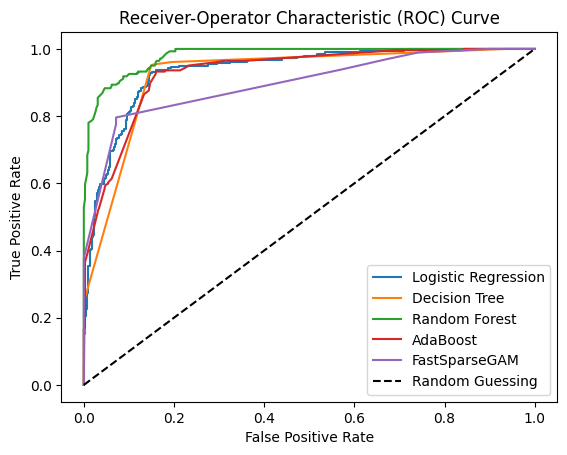

In [ ]:

plt.plot(logistic_results['fpr'], logistic_results['tpr'], label = 'Logistic Regression')
plt.plot(dt_results['fpr'], dt_results['tpr'], label = 'Decision Tree')
plt.plot(rf_results['fpr'], rf_results['tpr'], label = 'Random Forest')
plt.plot(ada_results['fpr'], ada_results['tpr'], label = 'AdaBoost')
plt.plot(fpr, tpr, label = 'FastSparseGAM')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing')
plt.title("Receiver-Operator Characteristic (ROC) Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

l0               1.61276
support_size           6
intercept       8.632122
converged           True
l2                   0.0
Name: 22, dtype: object 
 0.8622448979591837


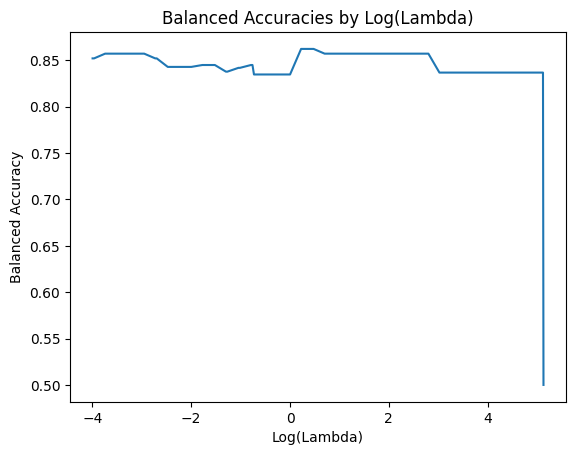

l0               1.61276
support_size           6
intercept       8.632122
converged           True
l2                   0.0
Name: 22, dtype: object
[0.0, 0.7641298250300521, 1.0] [-3.69993121 -3.69993121  0.        ] Age


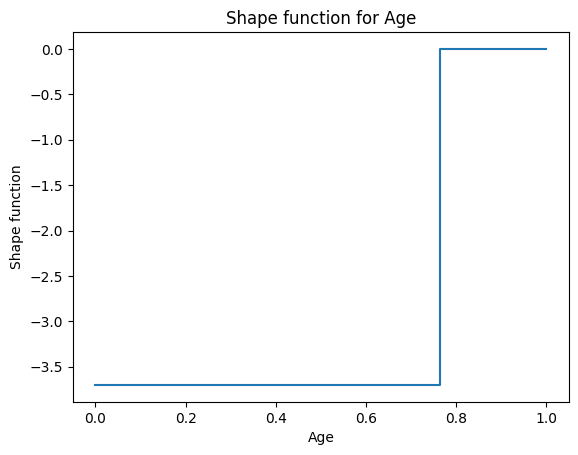

[0, 0.5, 1] [8.63212168 8.63212168 0.        ] IDH1


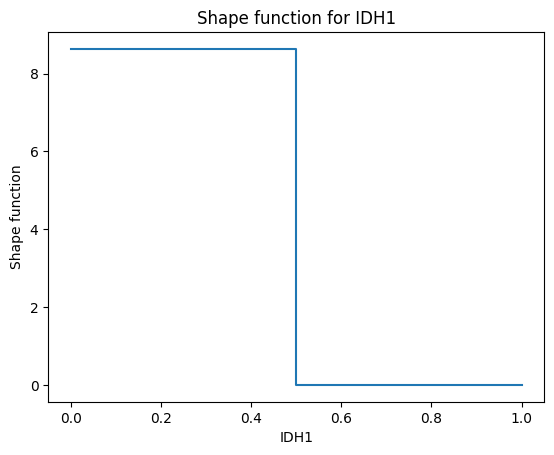

[0, 0.5, 1] [-6.1231102 -6.1231102  0.       ] IDH2


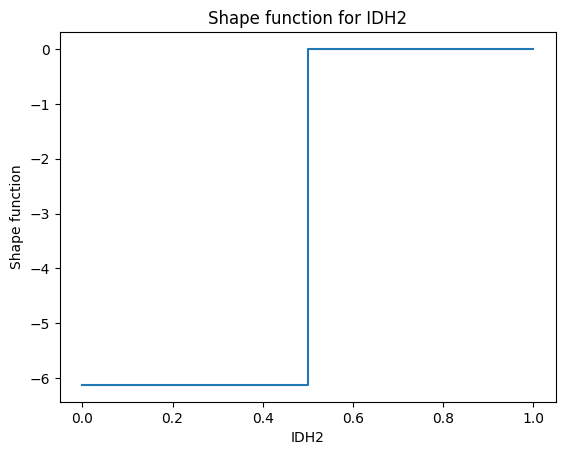

[0, 0.5, 1] [1.68842131 1.68842131 0.        ] NOTCH1


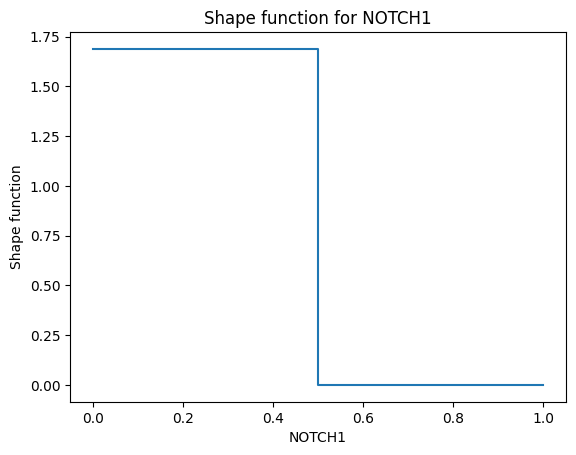

[0, 0.5, 1] [1.30485354 1.30485354 0.        ] PIK3R1


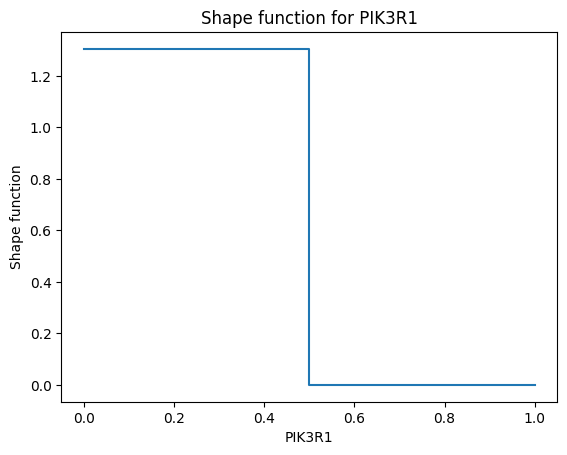

[0, 0.5, 1] [-4.79376054 -4.79376054  0.        ] TP53


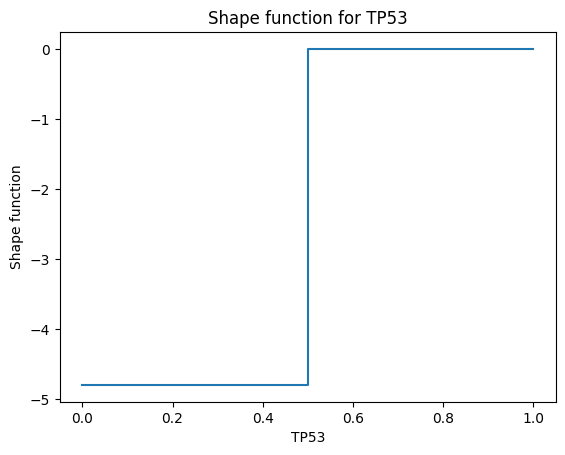

In [ ]:

accuracies = np.array(accuracies)
recalls = np.array(recalls)
best = models.characteristics().iloc[np.argmax(accuracies),:]
print(best, "\n", accuracies[np.argmax(accuracies)])

plt.title("Balanced Accuracies by Log(Lambda)")
plt.xlabel("Log(Lambda)")
plt.ylabel("Balanced Accuracy")
plt.plot(np.log(possible_lambdas), accuracies)
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_binary, models.predict(X_test_binary, lambda_0 = best['l0']))

print(best)
plot_shape_functions_fastsparse(models, X_train_binary.columns, X_test_proc, lambda_0 = best['l0'])

In [ ]:
def extract_stump_info(stump):
    """Get the feature, threshold value, and the predictions at each leaf node
    for a decision stump implemented in scikit-learn's DecisionTreeClassifier format.

    Parameters:
        stump (tree.DecisionTreeClassifier): The decision stump.

    Returns:
        tuple: A tuple containing the feature, threshold value,
            and the predictions at each leaf node.
    """
    feature = stump.tree_.feature[0]
    threshold = stump.tree_.threshold[0]

    leq_values = stump.tree_.value[1][0]
    gt_values = stump.tree_.value[2][0]

    return feature, threshold, leq_values, gt_values


def get_sklearn_adaboost_coeffs(adaboost, columns):
    """Get the coefficients of the decision tree splits in an AdaBoost model.

    Parameters:
        adaboost: The trained AdaBoost model.
        columns: The column names of the input data.

    Returns:
        pandas.DataFrame: The coefficients of the decision tree splits.
    """

    features, thresholds, leq_preds, gt_preds = [], [], [], []
    weights = adaboost.estimator_weights_
    for i, dtree in enumerate(adaboost.estimators_):
        feature, threshold, leq_values, gt_values = extract_stump_info(dtree)
        features.append(columns[feature])
        thresholds.append(threshold)
        leq_preds.append(np.argmax(leq_values) * weights[i])
        gt_preds.append(np.argmax(gt_values) * weights[i])
    adaboost_coeffs = pd.DataFrame({
        "Feature": features,
        "Split": thresholds,
        "< coeff": leq_preds,
        "> coeff": gt_preds
    })
    return adaboost_coeffs


def get_sklearn_rf_coeffs(rf, columns):
    """Get the coefficients of the decision tree splits in a tree-based sklearn ensemble.

    Parameters:
        rf: The trained random forest model.
        columns: The column names of the input data.

    Returns:
        pandas.DataFrame: The coefficients of the decision tree splits.
    """
    features, thresholds, leq_preds, gt_preds = [], [], [], []
    for dtree in rf.estimators_:
        feature, threshold, leq_values, gt_values = extract_stump_info(dtree)
        features.append(columns[feature])
        thresholds.append(threshold)
        leq_preds.append(leq_values[1] / (leq_values[0] + leq_values[1]))
        gt_preds.append(gt_values[1] / (gt_values[0] + gt_values[1]))
    rf_coeffs = pd.DataFrame({"Feature": features, "Split": thresholds, "< coeff": leq_preds, "> coeff": gt_preds})
    return rf_coeffs


def convert_coefficients_to_shape_function(coefficients, direction="<"):
    """Convert the gam feature coefficients to a step/shape function.

    This is needed to make the coefficient representation conform to the
    alignment expectations of plt.step, which are somewhat unintuitive.
    You can figure out how to do this yourself with a whiteboard and some patience,
    but I did that for you :)

    Parameters:
        coefficients (list[float]): The coefficients of the shape function.
        direction (str, optional): The direction of the step function.
            Can be "<" or ">". Defaults to "<".

    Returns:
        list[float]: The step function coefficients.
    """
    coefficients_steps = np.zeros(len(coefficients)+2)
    if direction == "<":
        coeff_reverse_cumsum = np.cumsum(coefficients[::-1])[::-1]
        coefficients_steps[1:-1] = coeff_reverse_cumsum
        coefficients_steps[0] = coeff_reverse_cumsum[0]
    else:
        coeff_cumsum = np.cumsum(coefficients)
        coefficients_steps[2:] = coeff_cumsum
    return coefficients_steps


def plot_shape_functions_tree_ensemble(ensemble, continuous_df):
    """Plot the shape functions of a tree ensemble model.

    Parameters:
        ensemble: The decision tree ensemble.
        continuous_df: The continuous dataframe used in the tree ensemble model.

    Returns:
        None
    """
    if isinstance(ensemble, AdaBoostClassifier):
        ensemble_df = get_sklearn_adaboost_coeffs(ensemble, continuous_df.columns)
    elif isinstance(ensemble, RandomForestClassifier):
        ensemble_df = get_sklearn_rf_coeffs(ensemble, continuous_df.columns)
    else:
        raise ValueError("Only AdaBoost and RandomForest models are supported")

    feature_names = np.unique(ensemble_df['Feature'])
    for feature_name in feature_names:
        feature_df = ensemble_df[ensemble_df['Feature'] == feature_name]
        feature_df = feature_df.sort_values('Split')
        steps = feature_df['Split'].to_numpy()

        feature_min = continuous_df[feature_name].min()
        feature_max = continuous_df[feature_name].max()
        steps = [feature_min] + list(steps) + [feature_max]

        coefficients_lt = feature_df['< coeff'].to_numpy()
        coefficients_gte = feature_df['> coeff'].to_numpy()
        coefficients_lt_steps = convert_coefficients_to_shape_function(coefficients_lt, direction="<")
        coefficients_gte_steps = convert_coefficients_to_shape_function(coefficients_gte, direction=">")
        coefficients = coefficients_lt_steps + coefficients_gte_steps

        plot_shape_function(steps, coefficients, feature_name)

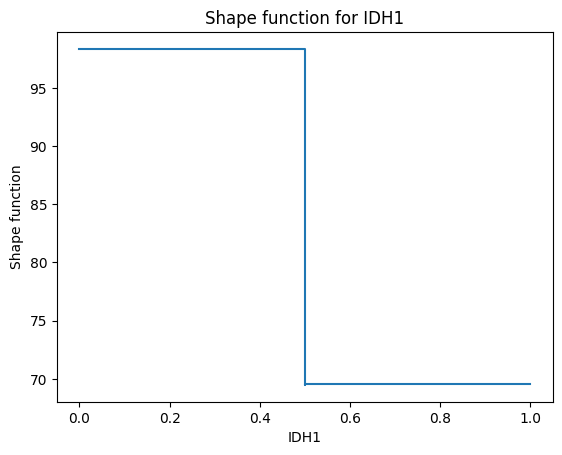

In [ ]:
plot_shape_functions_tree_ensemble(best_rforest, X_train_proc)

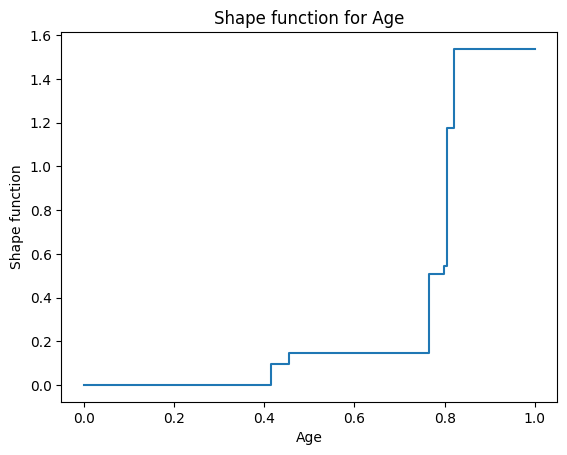

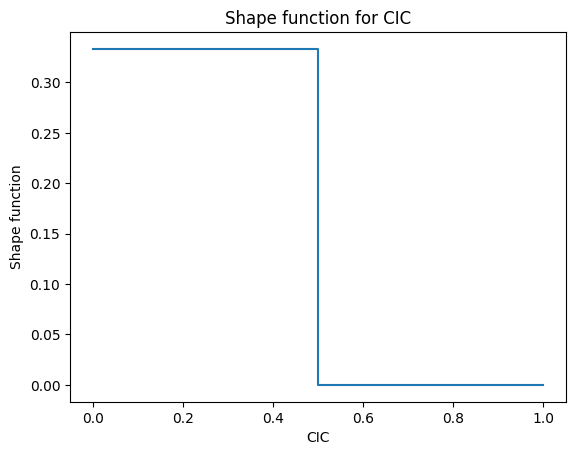

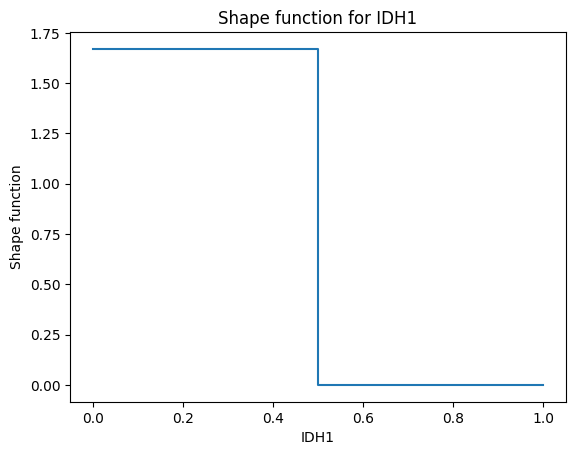

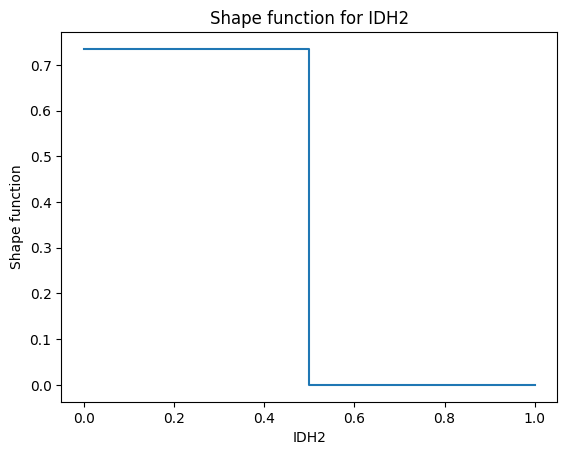

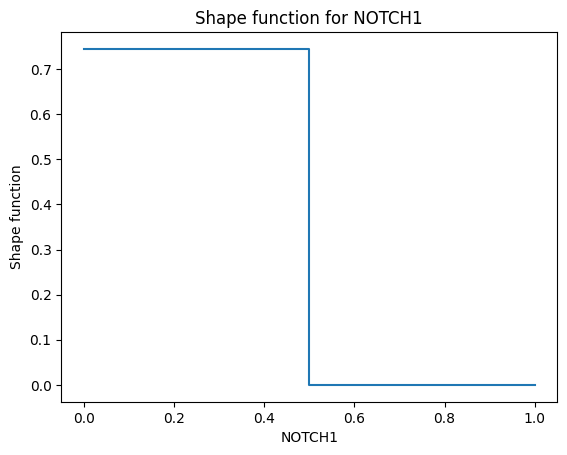

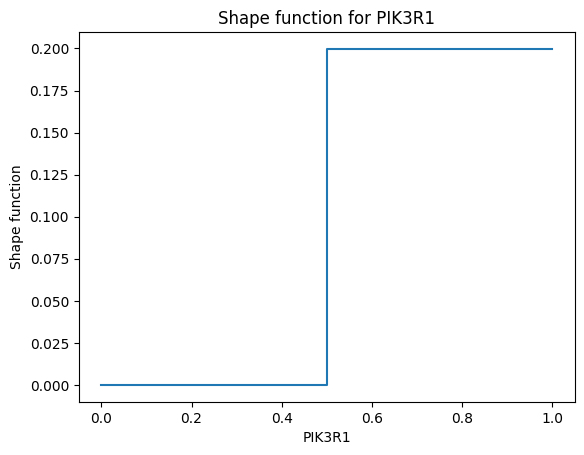

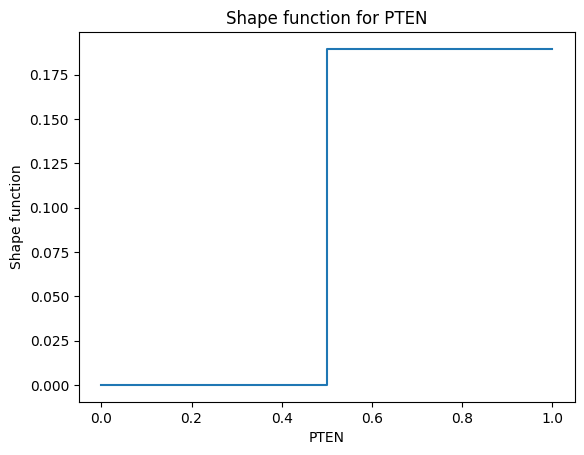

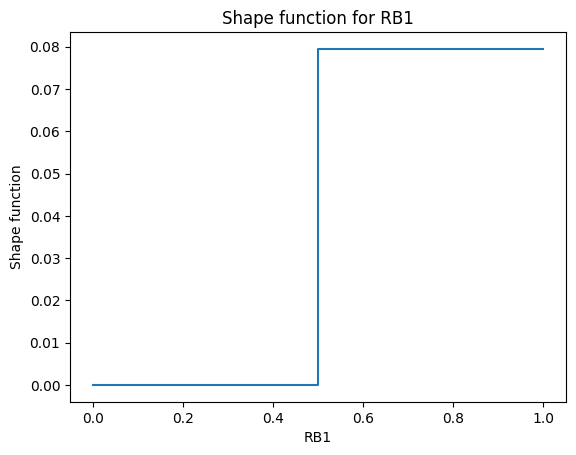

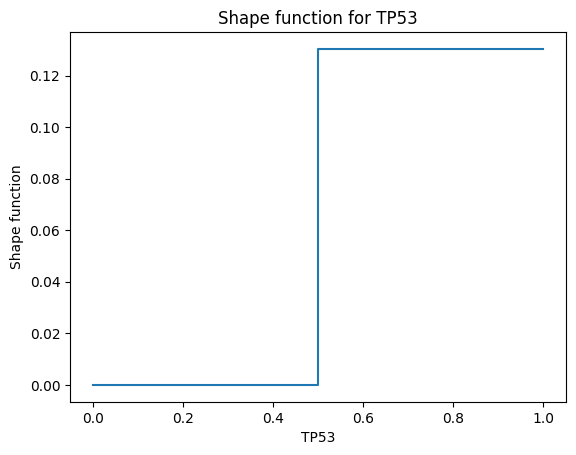

In [ ]:
plot_shape_functions_tree_ensemble(best_adaboost, X_train_proc)